In [116]:
# 1. Import thư viện cần thiết
from google.colab import files
uploaded = files.upload()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Saving SAB.csv to SAB.csv


In [118]:
df = pd.read_csv('SAB.csv')
df1=df.reset_index()['Price']

In [119]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

<h1># 4. Split the data into training, testing, and validation arcording to 7:2:1

In [120]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [121]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [122]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [123]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [124]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [125]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 52ms/step - loss: 0.0189 - val_loss: 0.0017
Epoch 2/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 3/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 4/100
13/13 [==============================] - 0s 19ms/step - loss: 9.6853e-04 - val_loss: 0.0018
Epoch 5/100
13/13 [==============================] - 0s 20ms/step - loss: 7.7586e-04 - val_loss: 0.0014
Epoch 6/100
13/13 [==============================] - 0s 19ms/step - loss: 6.2747e-04 - val_loss: 0.0014
Epoch 7/100
13/13 [==============================] - 0s 19ms/step - loss: 5.4799e-04 - val_loss: 0.0014
Epoch 8/100
13/13 [==============================] - 0s 19ms/step - loss: 5.1686e-04 - val_loss: 0.0014
Epoch 9/100
13/13 [==============================] - 0s 20ms/step - loss: 4.7351e-04 - val_loss: 0.0014
Epoch 10/100
13/13 [==============================] - 0s 19ms/step - loss: 4

In [126]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 24ms/step


In [127]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [128]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)


Validation RMSE: 3332.0020201031857
Testing RMSE: 7682.49539967205
Validate MAE:  3022.445891203705
Test MAE:  2450.470600328946
Validate MAPE:  5.213012541353143
Test MAPE:  1.9372413315112826


In [129]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[28:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.0202595]
101
1 day input [0.00171895 0.00472712 0.02191663 0.03266008 0.04254405 0.03781693
 0.03781693 0.03266008 0.02621401 0.02148689 0.02449506 0.02965191
 0.03394929 0.0318006  0.02879244 0.02922217 0.03094113 0.01761925
 0.02879244 0.03437903 0.03695746 0.04254405 0.03738719 0.03738719
 0.03609798 0.03308982 0.03824667 0.03996562 0.03996562 0.03953588
 0.03738719 0.03308982 0.02879244 0.02793296 0.02234637 0.02535453
 0.02449506 0.02449506 0.02234637 0.02449506 0.02750322 0.0249248
 0.02535453 0.02879244 0.03094113 0.03094113 0.02621401 0.02406532
 0.0249248  0.02277611 0.0193382  0.02191663 0.02062742 0.01761925
 0.01761925 0.01761925 0.01804899 0.02191663 0.01976794 0.01718951
 0.01718951 0.01074345 0.00429738 0.00687581 0.00386764 0.
 0.00515685 0.00300817 0.00300817 0.00429738 0.00644607 0.0090245
 0.00730554 0.00687581 0.00988397 0.00773528 0.00730554 0.0034379
 0.00128921 0.         0.00601633 0.00945423 0.00988397 0.00859476
 0.01117318 0.02062742 0.01847873 0.0159003  

In [ ]:
# Reshape x_input to the expected shape

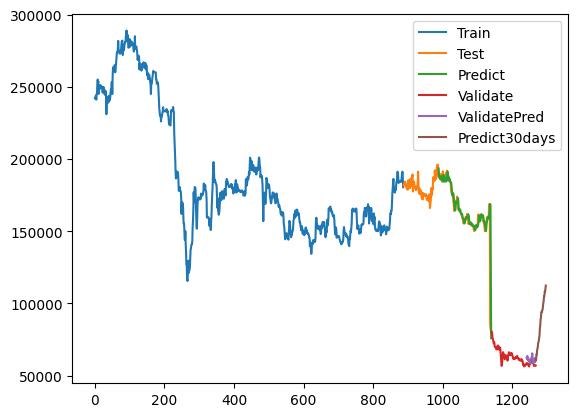

In [130]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

<h1># 4. Split the data into training, testing, and validation arcording to 5:3:2

In [131]:
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [132]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [133]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [134]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [135]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [136]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 2s 50ms/step - loss: 0.0418 - val_loss: 0.0024
Epoch 2/100
9/9 [==============================] - 0s 23ms/step - loss: 0.0048 - val_loss: 4.2058e-04
Epoch 3/100
9/9 [==============================] - 0s 23ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 4/100
9/9 [==============================] - 0s 22ms/step - loss: 0.0011 - val_loss: 4.5693e-04
Epoch 5/100
9/9 [==============================] - 0s 24ms/step - loss: 8.9856e-04 - val_loss: 7.0424e-04
Epoch 6/100
9/9 [==============================] - 0s 25ms/step - loss: 7.3484e-04 - val_loss: 3.2606e-04
Epoch 7/100
9/9 [==============================] - 0s 22ms/step - loss: 6.8148e-04 - val_loss: 3.4064e-04
Epoch 8/100
9/9 [==============================] - 0s 23ms/step - loss: 6.0641e-04 - val_loss: 3.0219e-04
Epoch 9/100
9/9 [==============================] - 0s 24ms/step - loss: 5.7379e-04 - val_loss: 2.9369e-04
Epoch 10/100
9/9 [==============================] - 0s 23ms/step - los

In [140]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 6ms/step


In [141]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [142]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 19617269111.86621
Testing RMSE: 39976883814.797386
Validate MAE:  17987990396.16049
Test MAE:  39844316726.793686
Validate MAPE:  99.99955349325563
Test MAPE:  99.99956926871232


In [143]:
# 13. Dự báo 30 ngày tiếp theo

x_input=val_data[154:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]

n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.00250822]
101
1 day input [0.00171895 0.00472712 0.02191663 0.03266008 0.04254405 0.03781693
 0.03781693 0.03266008 0.02621401 0.02148689 0.02449506 0.02965191
 0.03394929 0.0318006  0.02879244 0.02922217 0.03094113 0.01761925
 0.02879244 0.03437903 0.03695746 0.04254405 0.03738719 0.03738719
 0.03609798 0.03308982 0.03824667 0.03996562 0.03996562 0.03953588
 0.03738719 0.03308982 0.02879244 0.02793296 0.02234637 0.02535453
 0.02449506 0.02449506 0.02234637 0.02449506 0.02750322 0.0249248
 0.02535453 0.02879244 0.03094113 0.03094113 0.02621401 0.02406532
 0.0249248  0.02277611 0.0193382  0.02191663 0.02062742 0.01761925
 0.01761925 0.01761925 0.01804899 0.02191663 0.01976794 0.01718951
 0.01718951 0.01074345 0.00429738 0.00687581 0.00386764 0.
 0.00515685 0.00300817 0.00300817 0.00429738 0.00644607 0.0090245
 0.00730554 0.00687581 0.00988397 0.00773528 0.00730554 0.0034379
 0.00128921 0.         0.00601633 0.00945423 0.00988397 0.00859476
 0.01117318 0.02062742 0.01847873 0.0159003 

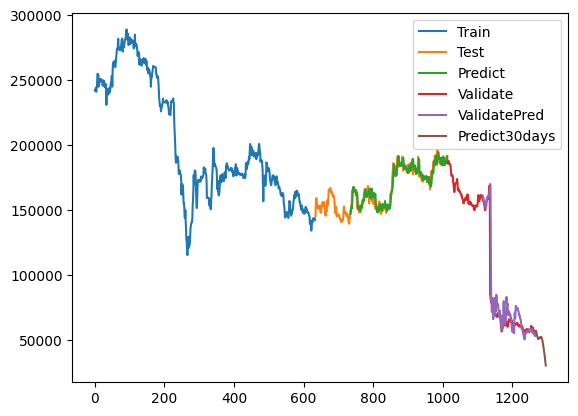

In [144]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()


<h1># 4. Split the data into training, testing, and validation arcording to 6:3:1

In [145]:
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [146]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [147]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [148]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [149]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [150]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 1s 42ms/step - loss: 0.0299 - val_loss: 0.0074
Epoch 2/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 3/100
11/11 [==============================] - 0s 22ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 4/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/100
11/11 [==============================] - 0s 22ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6/100
11/11 [==============================] - 0s 20ms/step - loss: 9.9403e-04 - val_loss: 0.0013
Epoch 7/100
11/11 [==============================] - 0s 22ms/step - loss: 9.5330e-04 - val_loss: 0.0013
Epoch 8/100
11/11 [==============================] - 0s 21ms/step - loss: 8.6413e-04 - val_loss: 0.0014
Epoch 9/100
11/11 [==============================] - 0s 23ms/step - loss: 8.4564e-04 - val_loss: 0.0013
Epoch 10/100
11/11 [==============================] - 0s 21ms/step - loss: 7.9424e-0

In [151]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 38ms/step


In [152]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [153]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 10107.181576651512
Testing RMSE: 6656.282767503155
Validate MAE:  9962.868778935184
Test MAE:  2704.123655913977
Validate MAPE:  17.123148133659505
Test MAPE:  1.854271680635745


In [154]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[28:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1



[0.05706974]
101
1 day input [0.00171895 0.00472712 0.02191663 0.03266008 0.04254405 0.03781693
 0.03781693 0.03266008 0.02621401 0.02148689 0.02449506 0.02965191
 0.03394929 0.0318006  0.02879244 0.02922217 0.03094113 0.01761925
 0.02879244 0.03437903 0.03695746 0.04254405 0.03738719 0.03738719
 0.03609798 0.03308982 0.03824667 0.03996562 0.03996562 0.03953588
 0.03738719 0.03308982 0.02879244 0.02793296 0.02234637 0.02535453
 0.02449506 0.02449506 0.02234637 0.02449506 0.02750322 0.0249248
 0.02535453 0.02879244 0.03094113 0.03094113 0.02621401 0.02406532
 0.0249248  0.02277611 0.0193382  0.02191663 0.02062742 0.01761925
 0.01761925 0.01761925 0.01804899 0.02191663 0.01976794 0.01718951
 0.01718951 0.01074345 0.00429738 0.00687581 0.00386764 0.
 0.00515685 0.00300817 0.00300817 0.00429738 0.00644607 0.0090245
 0.00730554 0.00687581 0.00988397 0.00773528 0.00730554 0.0034379
 0.00128921 0.         0.00601633 0.00945423 0.00988397 0.00859476
 0.01117318 0.02062742 0.01847873 0.0159003 

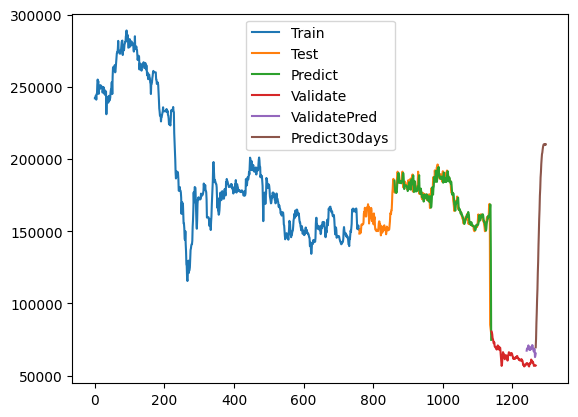

In [155]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()